In [1]:
import gensim
import pandas as pd
import spacy
import numpy as np
from wefe.word_embedding_model import WordEmbeddingModel
from wefe.metrics import RIPA
from wefe.query import Query

## Embeddings

In [2]:
# Load pre-trained Dutch FastText embeddings with Gensim
print("Loading word embeddings...")
nl_embeddings = gensim.models.KeyedVectors.load_word2vec_format("/Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/cc.nl.300.vec.gz", binary=False)
print("Embeddings loaded.")

Loading word embeddings...
Embeddings loaded.


In [3]:
# Convert to WEFE-compatible format
model = WordEmbeddingModel(nl_embeddings, "Dutch FastText")

In [4]:
# Load spaCy Dutch NLP model
nlp = spacy.load('nl_core_news_lg')

In [5]:
df = pd.read_csv("/Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/Corpus_Hedendaags_Nederlands_Adjectives.csv", sep=";")

## Functions

In [ ]:
def extract_adjectives_from_csv(file_path):
    """
    Leest een CSV-bestand in, waarbij alleen de eerste kolom (phrases/woordgroepen) gebruikt wordt.
    Vervolgens wordt elke phrase met spaCy geparsed om adjectives (ADJ) en nouns (NOUN) te onderscheiden
    en te lemmatiseren. Uiteindelijk retourneert deze functie alleen de gelemmatiseerde bijvoeglijke
    naamwoorden (adjectives).

    Parameters:
    - file_path: pad naar het CSV-bestand.

    Returns:
    - Een lijst met unieke, gelemmatiseerde bijvoeglijke naamwoorden (adjectives).
    """

    # 1. Lees het CSV-bestand in. 
    #    - delimiter=';' omdat jouw voorbeeldgegevens een puntkomma als scheidingsteken hebben
    #    - usecols=[0] om alleen de eerste kolom te nemen
    #    - names=["Group"] zodat de kolom een duidelijke naam krijgt
    #    - header=0 als de eerste regel al kolomnamen bevat. 
    #      Indien niet, gebruik header=None (afhankelijk van je bestand).
    df = pd.read_csv(file_path, delimiter=';', usecols=[0], names=["Group"], header=0)

    # 2. Verwijder eventuele lege rijen (NaN)
    df.dropna(subset=["Group"], inplace=True)

    # Lijst om alle gevonden adjectives (bijvoeglijke naamwoorden) in op te slaan
    adjectives = []

    # 3. Loop door elke phrase (bijv. "grote man", "vreemde vrouw", etc.)
    for phrase in df["Group"]:
        # Parse de phrase met spaCy
        doc = nlp(phrase)

        # 4. Bekijk elke token in de phrase
        for token in doc:
            # 5. Controleer of het token een bijvoeglijk naamwoord (ADJ) is
            if token.pos_ == "ADJ" and token.is_alpha:
                # 6. Voeg de lemma-vorm toe (bijv. 'grote' -> 'groot')
                #    We gebruiken .lower() om alles naar lowercase te zetten.
                adjectives.append(token.lemma_.lower())

    # 7. Verwijder duplicaten en behoud volgorde:
    #    - dict.fromkeys() houdt de eerste voorkomens in dezelfde volgorde
    adjectives = list(dict.fromkeys(adjectives))

    # 8. Retourneer de lijst met unieke bijvoeglijke naamwoorden
    return adjectives

# Voorbeeld van gebruik:
csv_file_path = "/Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/Corpus_Hedendaags_Nederlands_Adjectives.csv"
result_adjectives = extract_adjectives_from_csv(csv_file_path)
print("Unieke adjectives:", result_adjectives)

print(f"Total unique lemmas: {len(result_adjectives)}")
    
# Identificeer woorden die niet in het embeddingmodel zitten.
missing_words = [word for word in result_adjectives if word not in model]
print(f"Total missing words: {len(missing_words)}")
print("Sample missing words:", missing_words[:10])
    
# Houd alleen de woorden die in het embeddingmodel zitten.
filtered_lemmas = [word for word in result_adjectives if word in model]

# Filter woorden die specifieke doelwoorden bevatten.
target_words = [
       "man", "kerel", "jongen", "vader", "zoon", "vent", "gast", "meneer", "opa", "oom",
       "vrouw", "dame", "meisje", "moeder", "dochter", "tante", "oma", "mevrouw", "meid",
    ]

filtered_adjectives = [
        adj for adj in filtered_lemmas
        if not any(target_word in adj for target_word in target_words)
    ]

print(f"Remaining adjectives after final filtering: {len(filtered_adjectives)}")

Unieke adjectives: ['groot', 'vreemd', 'prachtig', 'onschuldig', 'vrouwelijk', 'angstig', 'koppig', 'uitzonderlijk', 'verkiesbaar', 'wilsonbekwame', 'ongerust', 'polygaum', 'wereldwijaz', 'praatgraag', 'teder', 'grof', 'grooot', 'schimmig', 'wereldwijze', 'polygame', 'onvriendelijk', 'wantrouwen', 'vervaarlijk', 'eervol', 'onsterfelijk', 'snobistisch', 'heimelijk', 'atypisch', 'wilsonbekwaam', 'wantrouwend', 'tegenstrijdig', 'rafelig', 'wereldwijs', 'polygaam', 'nadenken', 'panisch', 'onbestemd', 'eindig', 'onzelfzuchtig', 'droogkomisch', 'maatschappijkritisch', 'diepzinnig', 'vreemder', 'hondsbrutaal', 'ongrondwettig', 'etherisch', 'onalledaags', 'prinselijk', 'extern', 'onwerkelijk', 'wisselvallig', 'tumultueus', 'levenskrachtig', 'contraproductief', 'ongerussen', 'afdoende', 'pronkzuchtig', 'stemmig', 'mannek', 'wiebelig', 'geelgroen', 'grover', 'hengstig', 'gortdroog', 'zuidwaarts', 'manneke', 'geestelijk', 'alleenstaan', 'afwezig', 'gemiddeld', 'streng', 'louter', 'katholiek', 're

In [7]:
def cosine_similarity(v1: np.ndarray, v2: np.ndarray) -> float:
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def compute_association(w: np.ndarray, A: np.ndarray) -> float:
    return np.mean([cosine_similarity(w, a) for a in A])

def compute_attribute_association(X: np.ndarray, A: np.ndarray) -> np.ndarray:
    return np.array([compute_association(x, A) for x in X])

def compute_attribute_association_L2(A: np.ndarray, T: np.ndarray) -> np.ndarray:
    return np.array([compute_association(a, T) for a in A])

def compute_joint_std(X_Associations: np.ndarray, Y_Associations: np.ndarray) -> float:
    return np.std(np.concatenate([X_Associations, Y_Associations]), ddof=1)

def compute_p_value(X_Diff: np.ndarray, Y_Diff: np.ndarray, permutations: int=1000) -> float:
    test_statistic = np.sum(X_Diff) - np.sum(Y_Diff)
    empirical_distribution = np.array([np.random.choice(np.concatenate([X_Diff, Y_Diff]), size=len(X_Diff) + len(Y_Diff), replace=False) for _ in range(permutations)])
    empirical_differences = np.sum(empirical_distribution[:, :len(X_Diff)], axis=1) - np.sum(empirical_distribution[:, len(X_Diff):], axis=1)
    
    return 1-norm.cdf(test_statistic, loc=np.mean(empirical_differences), scale=np.std(empirical_differences, ddof=1))

def level_1(X: np.ndarray, Y: np.ndarray, A: np.ndarray, B: np.ndarray, permutations: int=1000) -> float:
    X_Associations_A = compute_attribute_association(X, A)
    X_Associations_B = compute_attribute_association(X, B)
    X_Differential_Associations = X_Associations_A - X_Associations_B

    Y_Associations_A = compute_attribute_association(Y, A)
    Y_Associations_B = compute_attribute_association(Y, B)
    Y_Differential_Associations = Y_Associations_A - Y_Associations_B

    X_Mean = np.mean(X_Differential_Associations)
    Y_Mean = np.mean(Y_Differential_Associations)

    p_value = compute_p_value(X_Differential_Associations, Y_Differential_Associations, permutations=permutations)

    return (X_Mean - Y_Mean) / compute_joint_std(X_Differential_Associations, Y_Differential_Associations), p_value

def level_2(T: np.ndarray, A: np.ndarray, B: np.ndarray, permutations: int=1000) -> float:
    A_Associations_T = compute_attribute_association_L2(A, T)
    B_Associations_T = compute_attribute_association_L2(B, T)

    p_value = compute_p_value(A_Associations_T, B_Associations_T, permutations=permutations)

    return (np.mean(A_Associations_T) - np.mean(B_Associations_T)) / compute_joint_std(A_Associations_T, B_Associations_T), p_value

def level_3(T: np.ndarray, A: np.ndarray) -> float:
    T_Associations_A = [cosine_similarity(t, a) for t in T for a in A]
    return np.mean(T_Associations_A), np.std(T_Associations_A, ddof=1)

def ML_EAT(A: np.ndarray, B: np.ndarray, X: np.ndarray, Y: np.ndarray, permutations: int=1000) -> dict:
    L1_effect_size, L1_p_value = level_1(X, Y, A, B, permutations=permutations)
    L2_effect_size_X, L2_p_value_X = level_2(X, A, B, permutations=permutations)
    L2_effect_size_Y, L2_p_value_Y = level_2(Y, A, B, permutations=permutations)
    L3_mean_AX, L3_std_AX = level_3(X, A)
    L3_mean_BX, L3_std_BX = level_3(X, B)
    L3_mean_AY, L3_std_AY = level_3(Y, A)
    L3_mean_BY, L3_std_BY = level_3(Y, B)

    return {
        'L1_effect_size': L1_effect_size,
        'L1_p_value': L1_p_value,
        'L2_effect_size_X': L2_effect_size_X,
        'L2_p_value_X': L2_p_value_X,
        'L2_effect_size_Y': L2_effect_size_Y,
        'L2_p_value_Y': L2_p_value_Y,
        'L3_mean_AX': L3_mean_AX,
        'L3_std_AX': L3_std_AX,
        'L3_mean_BX': L3_mean_BX,
        'L3_std_BX': L3_std_BX,
        'L3_mean_AY': L3_mean_AY,
        'L3_std_AY': L3_std_AY,
        'L3_mean_BY': L3_mean_BY,
        'L3_std_BY': L3_std_BY,
    }
def get_np_embeddings(target_words: list,
                      vocab_dict: dict,
                      embeddings: np.ndarray) -> np.ndarray:
    """
    Get the embeddings for the target words.
    """

    return np.array([embeddings[vocab_dict[word]] for word in target_words])

In [ ]:
def cosine_similarity(v1: np.ndarray, v2: np.ndarray) -> float:
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def compute_bias(adj, male_terms, female_terms, model):
    male_mean = np.mean([cosine_similarity(model[adj], model[m]) for m in male_terms if m in model])
    female_mean = np.mean([cosine_similarity(model[adj], model[f]) for f in female_terms if f in model])
    return male_mean - female_mean

# NIEUWE Functie: voeg een permutatietest toe voor statistische significantie
def compute_bias_with_pvalue(adj, male_terms, female_terms, model, permutations=1000, seed=42):
    np.random.seed(seed)

    # echte bias-score berekenen
    real_bias = compute_bias(adj, male_terms, female_terms, model)

    combined_terms = male_terms + female_terms
    num_male = len(male_terms)
    
    extreme_count = 0

    for _ in range(permutations):
        np.random.shuffle(combined_terms)
        permuted_male = combined_terms[:num_male]
        permuted_female = combined_terms[num_male:]

        # bereken bias-score onder permutatie
        permuted_bias = compute_bias(adj, permuted_male, permuted_female, model)

        # kijk of permuted bias extremer is dan echte bias
        if abs(permuted_bias) >= abs(real_bias):
            extreme_count += 1

    # Bereken de p-waarde:
    p_value = extreme_count / permutations

    return real_bias, p_value


## Global Variables

In [10]:
MALE_WORDS = [
     "man", "kerel", "jongen", "vader", "zoon", "vent", "gast", "meneer", "opa", "oom",
]
FEMALE_WORDS = [
    "vrouw", "dame", "meisje", "moeder", "dochter", "tante", "oma", "mevrouw", "meid",
]

## Cosine Similarity Bias

In [11]:
results = []

for adj in filtered_adjectives:
    if adj in model:
        bias, pval = compute_bias_with_pvalue(adj, MALE_WORDS, FEMALE_WORDS, model)
        results.append({'word': adj, 'bias': bias, 'p_value': pval})

# Maak hier een dataframe van:
df_bias_pval = pd.DataFrame(results)

# Sorteer op p-waarde of bias
df_bias_pval_sorted = df_bias_pval.sort_values(by='p_value')


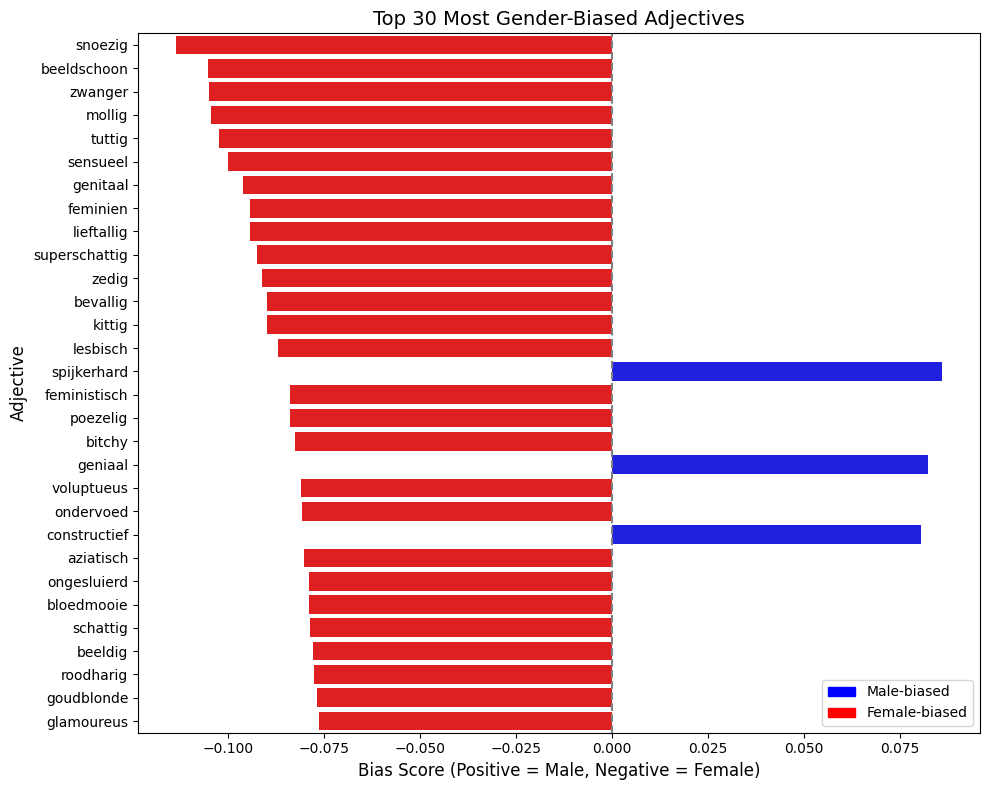

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  'df_bias_pval' containing:
# columns: ['word', 'bias', 'p_value']

# First, get the top 30 adjectives based on absolute bias
df_bias_pval['abs_bias'] = df_bias_pval['bias'].abs()
top30_bias = df_bias_pval.sort_values(by='abs_bias', ascending=False).head(30)

# Add a column to specify gender-bias direction (for coloring)
top30_bias['gender'] = top30_bias['bias'].apply(lambda x: 'male' if x > 0 else 'female')

# Define colors: blue for male, red for female
palette = {'male': 'blue', 'female': 'red'}

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(
    x='bias',
    y='word',
    data=top30_bias,
    hue='gender',
    palette=palette,
    dodge=False
)

plt.title('Top 30 Most Gender-Biased Adjectives', fontsize=14)
plt.xlabel('Bias Score (Positive = Male, Negative = Female)', fontsize=12)
plt.ylabel('Adjective', fontsize=12)
plt.axvline(0, color='grey', linestyle='--')

# Adding legend manually
from matplotlib.patches import Patch
legend_handles = [Patch(color='blue', label='Male-biased'),
                  Patch(color='red', label='Female-biased')]
plt.legend(handles=legend_handles, loc='lower right')

plt.tight_layout()
plt.show()


In [13]:
def compute_individual_bias(
    adjectives,
    male_terms,
    female_terms,
    model,
    exclude_substrings=True
):
    """
    Berekent voor elk bijvoeglijk naamwoord (ADJ) het 'bias'-verschil 
    tussen gemiddelde cosinesim. met mannelijke termen en 
    gemiddelde cosinesim. met vrouwelijke termen.

    Parameters
    ----------
    adjectives : list of str
        De lijst van te analyseren bijvoeglijke naamwoorden (al schoongemaakt/gelmmatized).
    male_terms : list of str
        Woorden die 'mannelijkheid' representeren (bijv. ['man','jongen','vader',...]).
    female_terms : list of str
        Woorden die 'vrouwelijkheid' representeren (bijv. ['vrouw','meisje','dame',...]).
    model : dict-like of {str -> np.ndarray} of a KeyedVectors-like object
        Jouw embeddingmodel, waarbij je `word in model` kunt checken en `model[word]`
        de vector geeft.
    exclude_substrings : bool, default=True
        Of we woorden moeten overslaan die 'male_terms' of 'female_terms' 
        als substring bevatten (bijv. "mannenachtig" bevat "man").

    Returns
    -------
    pd.DataFrame
        DataFrame met kolommen:
        ['word', 'male_mean', 'female_mean', 'bias_value'].
        Waar 'bias_value' = male_mean - female_mean.
        Rijen waar niet genoeg info (embeddings) beschikbaar was, worden overgeslagen.
    """

    # 1) Optioneel substring-filter:
    if exclude_substrings:
        all_target_words = set(male_terms + female_terms)
        def has_target_substring(adj):
            return any(tw in adj for tw in all_target_words)
        adjectives = [adj for adj in adjectives if not has_target_substring(adj)]

    records = []

    # 2) Loop over elke adjective
    for adj in adjectives:
        # Check of het adj in het model zit
        if adj not in model:
            continue

        adj_vec = model[adj]

        # Verzamel cosines met mannelijke termen
        male_sims = []
        for m in male_terms:
            if m in model:
                male_sims.append(cosine_similarity(adj_vec, model[m]))

        # Verzamel cosines met vrouwelijke termen
        female_sims = []
        for f in female_terms:
            if f in model:
                female_sims.append(cosine_similarity(adj_vec, model[f]))

        # Check of we beide lijsten niet leeg zijn
        if len(male_sims) == 0 or len(female_sims) == 0:
            # Dan kunnen we geen bias berekenen
            continue

        # Gemiddelde cosines
        male_mean = np.mean(male_sims)
        female_mean = np.mean(female_sims)

        # Bias = verschil man - vrouw
        bias_value = male_mean - female_mean

        records.append({
            "word": adj,
            "male_mean": male_mean,
            "female_mean": female_mean,
            "bias_value": bias_value
        })

    # Omzetten naar DataFrame
    df_bias = pd.DataFrame(records)

    return df_bias

individual_bias = compute_individual_bias(adjectives=filtered_adjectives, male_terms=MALE_WORDS, female_terms=FEMALE_WORDS, model=model)
print(f"Totaal aantal berekende bias-waarden: {len(individual_bias)}")
    
    # Sorteer oplopend op 'bias_value'
df_sorted = individual_bias.sort_values("bias_value", ascending=True)

    # Selecteer de 30 laagste scores
lowest_30 = df_sorted.head(30)

    # Selecteer de 30 hoogste scores
highest_30 = df_sorted.tail(30)

print("=== 30 Laagste Scores (bias_value) ===")
for _, row in lowest_30.iterrows():
    print(f"{row['word']}: {row['bias_value']:.4f} "
            f"(male_mean={row['male_mean']:.4f}, female_mean={row['female_mean']:.4f})")

print("\n=== 30 Hoogste Scores (bias_value) ===")
for _, row in highest_30.iloc[::-1].iterrows():
    print(f"{row['word']}: {row['bias_value']:.4f} "
        f"(male_mean={row['male_mean']:.4f}, female_mean={row['female_mean']:.4f})")
    
df_sorted_male = individual_bias.sort_values("male_mean", ascending=False)
top_30_male_mean = df_sorted_male.head(30)

print("\n=== 30 Hoogste male_mean (onafhankelijk van female_mean) ===")
for _, row in top_30_male_mean.iterrows():
    print(f"{row['word']} - male_mean={row['male_mean']:.4f}, "
          f"female_mean={row['female_mean']:.4f}, bias={row['bias_value']:.4f}")

# En idem voor female_mean
df_sorted_female = individual_bias.sort_values("female_mean", ascending=False)
top_30_female_mean = df_sorted_female.head(30)

print("\n=== 30 Hoogste female_mean (onafhankelijk van male_mean) ===")
for _, row in top_30_female_mean.iterrows():
    print(f"{row['word']} - female_mean={row['female_mean']:.4f}, "
          f"male_mean={row['male_mean']:.4f}, bias={row['bias_value']:.4f}")

Totaal aantal berekende bias-waarden: 2763
=== 30 Laagste Scores (bias_value) ===
snoezig: -0.1134 (male_mean=0.1708, female_mean=0.2842)
beeldschoon: -0.1051 (male_mean=0.1756, female_mean=0.2807)
zwanger: -0.1050 (male_mean=0.2770, female_mean=0.3821)
mollig: -0.1045 (male_mean=0.2298, female_mean=0.3343)
tuttig: -0.1022 (male_mean=0.1455, female_mean=0.2477)
sensueel: -0.1000 (male_mean=0.0977, female_mean=0.1978)
genitaal: -0.0961 (male_mean=0.0965, female_mean=0.1925)
feminien: -0.0943 (male_mean=0.1307, female_mean=0.2250)
lieftallig: -0.0942 (male_mean=0.3143, female_mean=0.4085)
superschattig: -0.0923 (male_mean=0.1645, female_mean=0.2568)
zedig: -0.0912 (male_mean=0.1646, female_mean=0.2558)
bevallig: -0.0898 (male_mean=0.1945, female_mean=0.2843)
kittig: -0.0897 (male_mean=0.2503, female_mean=0.3401)
lesbisch: -0.0870 (male_mean=0.2153, female_mean=0.3023)
feministisch: -0.0839 (male_mean=0.1812, female_mean=0.2651)
poezelig: -0.0837 (male_mean=0.2382, female_mean=0.3219)
bit

In [14]:
individual_bias_dict = individual_bias.set_index("word")["bias_value"].to_dict()
search_words = ["sterk", "zacht", "moedig", "emotioneel", "dominant", 
                "zorgzaam", "aardig", "knap", "schattig"]

print("Bias scores voor specifieke woorden:")
for word in search_words:
    # Let op: als je bij de filtering alles lowercase hebt gemaakt, doe je hier ook word.lower()
    w_lower = word.lower()
    bias_value = individual_bias_dict.get(w_lower)

    if bias_value is not None:
        print(f"{word}: {bias_value:.3f}")
    else:
        print(f"{word}: Niet gevonden in df_bias (of model).")


Bias scores voor specifieke woorden:
sterk: 0.031
zacht: -0.011
moedig: 0.023
emotioneel: -0.023
dominant: 0.015
zorgzaam: -0.025
aardig: 0.015
knap: -0.013
schattig: -0.079


## RIPA

In [15]:
print(f"Number of adjectives (filtered_lemmas): {len(filtered_adjectives)}")

# Define the query
query = Query(
    target_sets=[
        ["man", "kerel", "jongen", "vader", "zoon", "vent", "meneer", "opa", "oom"],
        ["vrouw", "dame", "meisje", "moeder", "dochter", "tante", "oma", "mevrouw", "meid"]],
    attribute_sets=[filtered_adjectives],  # Ensure it's a list of lists
    target_sets_names=["Male Terms", "Female Terms"],
    attribute_sets_names=["Adjectives"],
)

ripa = RIPA()
result = ripa.run_query(query, model)


print(result)

Number of adjectives (filtered_lemmas): 2763
{'query_name': 'Male Terms and Female Terms wrt Adjectives', 'result': 0.03312402, 'ripa': 0.03312402, 'word_values': {'groot': {'mean': 0.06565977, 'std': 0.09056313}, 'vreemd': {'mean': 0.06272587, 'std': 0.07452034}, 'prachtig': {'mean': 0.00971807, 'std': 0.070599884}, 'onschuldig': {'mean': 0.021620125, 'std': 0.06400034}, 'angstig': {'mean': 0.030293992, 'std': 0.069958165}, 'koppig': {'mean': 0.070308, 'std': 0.103406474}, 'uitzonderlijk': {'mean': 0.021257145, 'std': 0.025638085}, 'verkiesbaar': {'mean': 0.03710917, 'std': 0.044732075}, 'wilsonbekwame': {'mean': 0.020487094, 'std': 0.055293802}, 'ongerust': {'mean': 0.01929689, 'std': 0.060759675}, 'praatgraag': {'mean': 0.012409742, 'std': 0.04473654}, 'teder': {'mean': 0.0075335554, 'std': 0.160361}, 'grof': {'mean': 0.11639285, 'std': 0.13339995}, 'grooot': {'mean': 0.020882986, 'std': 0.07195975}, 'schimmig': {'mean': 0.04021907, 'std': 0.053056106}, 'wereldwijze': {'mean': 0.041

In [ ]:
# 'result["word_values"]' {woord: {'mean': x, 'std': y}, ...}
df_ripa = pd.DataFrame({
    'Word': result["word_values"].keys(),
    'Mean Score': [val['mean'] for val in result["word_values"].values()],
    'Std Dev': [val['std'] for val in result["word_values"].values()],
})

# Sorteer op Mean Score (die RIPA per woord toekent) en bekijk
df_ripa = df_ripa.sort_values(by="Mean Score", ascending=False).reset_index(drop=True)
for word in search_words:
    if word in result["word_values"]:
        mean_val = result["word_values"][word]["mean"]
        std_val = result["word_values"][word]["std"]
        print(f"{word}: Mean={mean_val:.3f}, Std={std_val:.3f}")
    else:
        print(f"{word}: niet gevonden in RIPA-result.")


sterk: Mean=0.074, Std=0.095
zacht: Mean=0.037, Std=0.107
moedig: Mean=0.082, Std=0.093
emotioneel: Mean=0.018, Std=0.064
dominant: Mean=0.039, Std=0.063
zorgzaam: Mean=0.026, Std=0.095
aardig: Mean=0.054, Std=0.090
knap: Mean=0.074, Std=0.154
schattig: Mean=-0.015, Std=0.084


In [17]:
# 1) Voeg een Z-score-kolom toe:
mean_of_scores = df_ripa["Mean Score"].mean()
std_of_scores = df_ripa["Mean Score"].std()

df_ripa["Z-Score"] = (df_ripa["Mean Score"] - mean_of_scores) / std_of_scores

# 2) Als je daarna wilt sorteren op Z-Score (hoog -> laag), doe je:
df_ripa = df_ripa.sort_values("Z-Score", ascending=False).reset_index(drop=True)

# 3) Print de eerste rijen om te zien hoe de Z-scores eruitzien:
print(df_ripa.head(10))
print(df_ripa.tail(10))

    Word  Mean Score   Std Dev   Z-Score
0    lui    0.235836  0.214274  7.961461
1    laf    0.212236  0.154480  7.034599
2    arm    0.189425  0.302302  6.138696
3   dood    0.184128  0.239391  5.930670
4   luie    0.174830  0.187741  5.565491
5    gay    0.169829  0.309285  5.369054
6   sluw    0.168590  0.086148  5.320414
7    dom    0.168325  0.190239  5.309994
8    oud    0.163380  0.383950  5.115796
9  rebel    0.155091  0.158283  4.790244
          Word  Mean Score   Std Dev   Z-Score
2753     zedig   -0.036648  0.116245 -2.740270
2754  genitaal   -0.037653  0.077058 -2.779741
2755  feminien   -0.040469  0.073521 -2.890345
2756  pregnant   -0.044425  0.046941 -3.045739
2757       pip   -0.045646  0.136830 -3.093678
2758   snoezig   -0.052402  0.093561 -3.359013
2759     zwoel   -0.058821  0.099972 -3.611130
2760    tuttig   -0.059465  0.104800 -3.636422
2761  sensueel   -0.060514  0.084249 -3.677614
2762      chic   -0.066409  0.149293 -3.909130


In [24]:
df_combined = pd.merge(
    df_bias_pval,
    df_ripa[['Word', 'Mean Score']],
    left_on='word',
    right_on='Word',
    how='inner'
).rename(columns={'Mean Score': 'RIPA_score'})
df_combined['cosine_bias_z'] = (df_combined['bias'] - df_combined['bias'].mean()) / df_combined['bias'].std()
df_combined['ripa_z'] = (df_combined['RIPA_score'] - df_combined['RIPA_score'].mean()) / df_combined['RIPA_score'].std()
# verwijder overtollige kolom
df_combined.drop('Word', axis=1, inplace=True)

# voorbeeld inspectie
print(df_combined.head())


         word      bias  p_value  abs_bias  RIPA_score  cosine_bias_z  \
0       groot  0.024243    0.355  0.024243    0.065660       0.657341   
1      vreemd  0.025999    0.197  0.025999    0.062726       0.723282   
2    prachtig -0.035693    0.100  0.035693    0.009718      -1.592315   
3  onschuldig -0.022002    0.515  0.022002    0.021620      -1.078402   
4     angstig -0.011887    0.652  0.011887    0.030294      -0.698751   

     ripa_z  
0  1.277835  
1  1.162607  
2 -0.919264  
3 -0.451813  
4 -0.111149  


Correlation between Cosine Similarity Bias and RIPA: r = 0.594, p = 0.0000


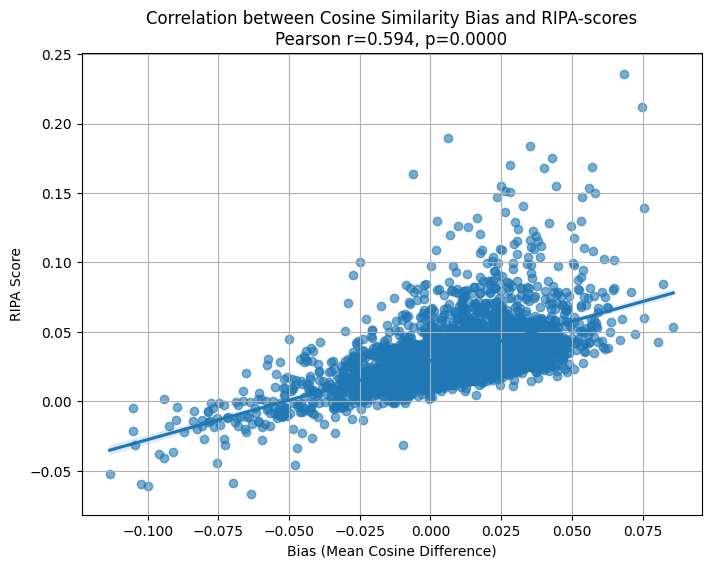

In [27]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Bereken Pearson correlatie
corr, p_corr = stats.pearsonr(df_combined['bias'], df_combined['RIPA_score'])
print(f"Correlation between Cosine Similarity Bias and RIPA: r = {corr:.3f}, p = {p_corr:.4f}")

# Scatterplot ter visualisatie:
plt.figure(figsize=(8, 6))
sns.regplot(x='bias', y='RIPA_score', data=df_combined, scatter_kws={'alpha':0.6})
plt.title(f"Correlation between Cosine Similarity Bias and RIPA-scores\nPearson r={corr:.3f}, p={p_corr:.4f}")
plt.xlabel("Bias (Mean Cosine Difference)")
plt.ylabel("RIPA Score")
plt.grid(True)
plt.show()


In [28]:
# Top 10 most similar scores between the two metrics
df_combined['score_diff'] = abs(df_combined['bias'] - df_combined['RIPA_score'])
consistent_words = df_combined.sort_values('score_diff').head(10)

print("Top 10 most similar scores between the two metrics:")
print(consistent_words[['word', 'bias', 'RIPA_score', 'score_diff']])

# Top 10 least similar scores between the two metrics
inconsistent_words = df_combined.sort_values('score_diff', ascending=False).head(10)

print("\nTop 10 least similar scores between the two metrics")
print(inconsistent_words[['word', 'bias', 'RIPA_score', 'score_diff']])


Top 10 most similar scores between the two metrics:
                   word      bias  RIPA_score  score_diff
2734        onpartijdig  0.037277    0.037270    0.000006
1096          effectief  0.027884    0.027963    0.000079
1528       betekenisvol  0.021418    0.021505    0.000087
2005      onbetrouwbaar  0.019633    0.019730    0.000097
1288  hoogstpersoonlijk  0.029358    0.029484    0.000126
1117          snoeihard  0.043280    0.043132    0.000148
927      overeenkomstig  0.019585    0.019393    0.000192
2144     aanschouwelijk  0.010669    0.010471    0.000198
602        nadrukkelijk  0.022870    0.023082    0.000213
133            aanwezig  0.029826    0.030056    0.000230

Top 10 least similar scores between the two metrics
      word      bias  RIPA_score  score_diff
1552   arm  0.006375    0.189425    0.183050
1137   oud -0.006236    0.163380    0.169616
2616   lui  0.068551    0.235836    0.167285
1141  dood  0.035276    0.184128    0.148852
2399   gay  0.028101    0.169829

In [29]:
df_combined.head(5)

,word,bias,p_value,abs_bias,RIPA_score,cosine_bias_z,ripa_z,score_diff
0,groot,0.024243,0.355,0.024243,0.065660,0.657341,1.277835,0.041417
1,vreemd,0.025999,0.197,0.025999,0.062726,0.723282,1.162607,0.036726
2,prachtig,-0.035693,0.100,0.035693,0.009718,-1.592315,-0.919264,0.045411
3,onschuldig,-0.022002,0.515,0.022002,0.021620,-1.078402,-0.451813,0.043622
4,angstig,-0.011887,0.652,0.011887,0.030294,-0.698751,-0.111149,0.042181


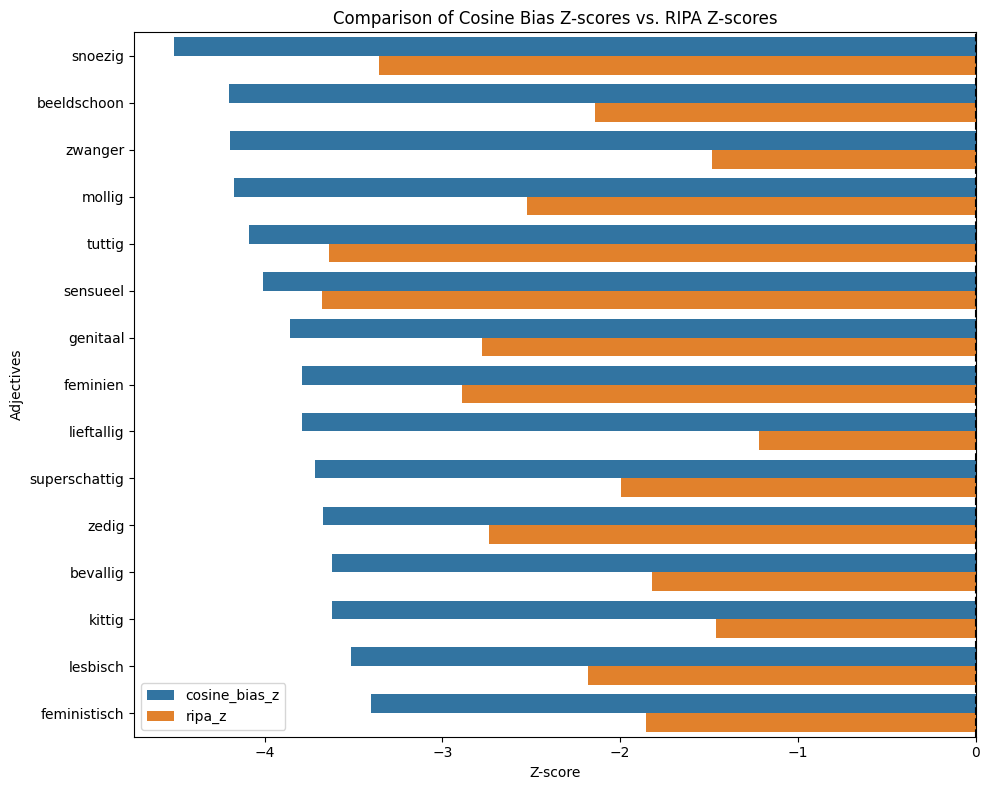

In [33]:
# 1) Pick the top 15 based on the absolute cosine z-score (or however you want to define "top")
top15_z = (
    df_combined
    .reindex(df_combined['cosine_bias_z'].abs().sort_values(ascending=False).index)
    .head(15)
)

# 2) Melt the dataframe so that `cosine_bias_z` and `ripa_z` become one column,
#    and we can use "Metric" as a hue in the barplot
df_melted = top15_z.melt(
    id_vars='word',
    value_vars=['cosine_bias_z', 'ripa_z'],
    var_name='Metric',
    value_name='Z_score'
)

# 3) Create a grouped bar chart
plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_melted,
    y='word', 
    x='Z_score',
    hue='Metric',
    orient='h'  # horizontal bars
)

# 4) Draw a reference line at zero
plt.axvline(0, color='black', linestyle='--')

# 5) Labeling
plt.xlabel('Z-score')
plt.ylabel('Adjectives')
plt.title('Comparison of Cosine Bias Z-scores vs. RIPA Z-scores')

# 6) Layout
plt.legend(loc='best')
plt.tight_layout()
plt.show()


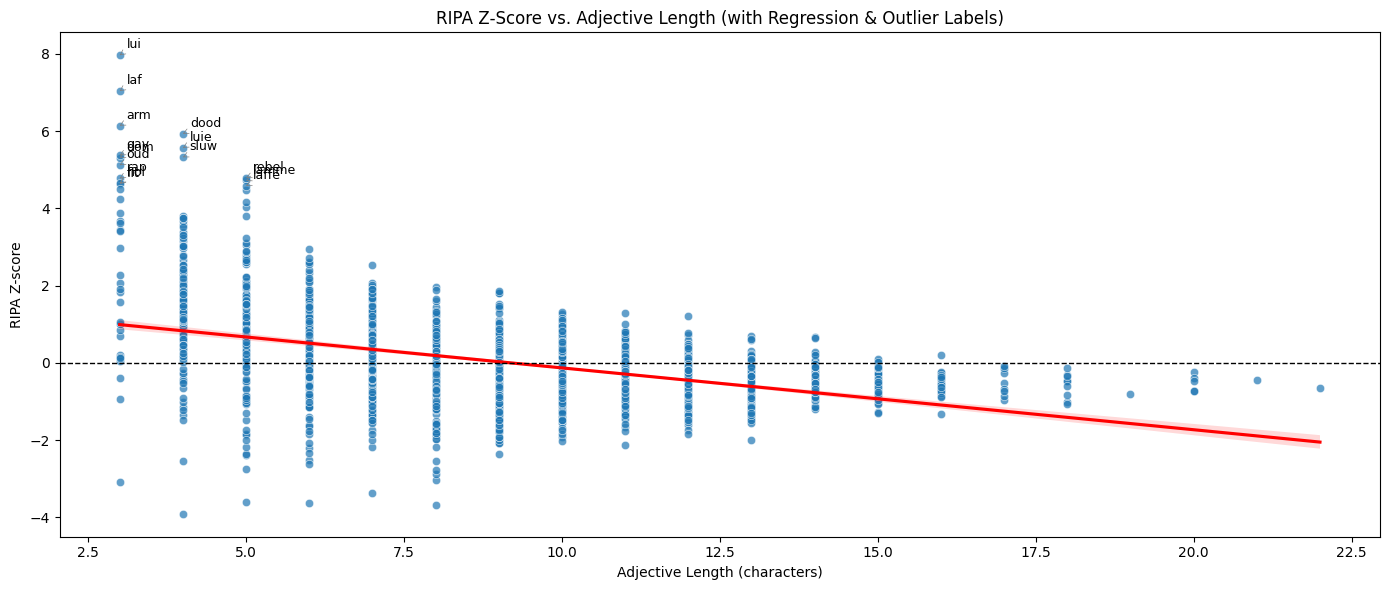

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make sure 'adjective_length' column exists
df_combined['adjective_length'] = df_combined['word'].str.len()

fig, ax = plt.subplots(figsize=(14, 6))

# --- 1) Scatter Plot ---
sns.scatterplot(
    data=df_combined,
    x='adjective_length',
    y='ripa_z',
    alpha=0.7,
    ax=ax
)

# --- 2) Regression Line ---
sns.regplot(
    data=df_combined,
    x='adjective_length',
    y='ripa_z',
    scatter=False,   # we already have scatter from above
    line_kws={'color': 'red'},
    ax=ax
)

# --- 3) Reference line at y=0 ---
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# --- 4) Outlier Annotation ---
# Filter rows where |ripa_z| > 4.5 (adjust threshold as desired)
threshold = 4.5
df_outliers = df_combined[df_combined['ripa_z'].abs() > threshold]

# Annotate each outlier
for i, row in df_outliers.iterrows():
    ax.annotate(
        text=row['word'],
        xy=(row['adjective_length'], row['ripa_z']),
        xytext=(5,5),  # offsets text a bit from the point
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
        fontsize=9
    )

# --- 5) Axis Labels, Title, Layout ---
ax.set_xlabel('Adjective Length (characters)')
ax.set_ylabel('RIPA Z‐score')
ax.set_title('RIPA Z‐Score vs. Adjective Length (with Regression & Outlier Labels)')
plt.tight_layout()
plt.show()


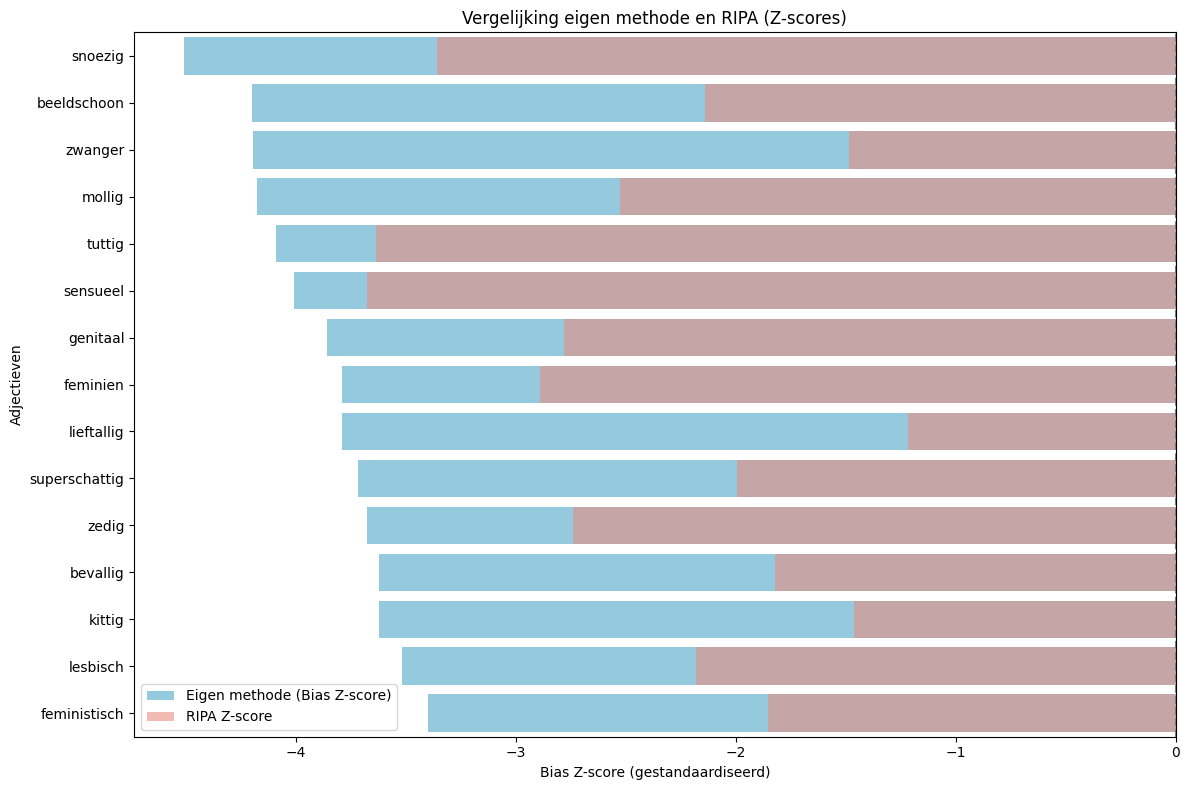

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kies top 15 adjectieven met hoogste absolute bias_z (van je eigen methode)
top15_z = df_combined.reindex(df_combined['bias_z'].abs().sort_values(ascending=False).index).head(15)

plt.figure(figsize=(12, 8))

# Plot eigen methode
sns.barplot(x='bias_z', y='word', data=top15_z, color='skyblue', label='Eigen methode (Bias Z-score)')

# Overlay RIPA Z-scores
sns.barplot(x='ripa_z', y='word', data=top15_z, color='salmon', alpha=0.6, label='RIPA Z-score')

# Visualisatie details
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('Bias Z-score (gestandaardiseerd)')
plt.ylabel('Adjectieven')
plt.title('Vergelijking eigen methode en RIPA (Z-scores)')
plt.legend()
plt.tight_layout()
plt.show()
